As a parent of a toddler, you deal with a multitude of potential problems on an ongoing basis. I personally find myself constantly worrying about wether or not my daughter's getting too much screen time; or if we're reading enough together; and when we are reading, if we're reading the right types of books; and also if I'm just spending the highest quality time with her. And, don't even get me started on mealtime...

The point is, as a parent, you have any number of things in the short term to entirely occupy your time, and if that's not enough, you also have your child's future to worry about as well. Luckily, if you have an interest in using data to predict the future, then that last one is actually quite a bit of fun! 

In this article, I'll go over the analysis that I performed when it came time to really start saving for my child's college education. In fact, this article is basically just a scrubbed (I removed personal information about my daughter) and slightly cleaned up version of what I presented to my wife (lucky woman)!

## Defining the Problem

Before we dive into the details, it's a good idea to quickly summarize what it is that we are attempting to do. Essentially, there's really only two steps to this analysis: (1) predicting the cost of college, and (2) calculating the preiodic payments that need to be made. The latter bit is pretty standard stuff, really nothing more than an application of the compounding interest forumula. The real meat of this article then is in the prediction step and that's what I'll concentrate on for the majority of this post.

but predicting the cost of college... Well, that's just fun! 

## The Setup

Let's start by taking a look at what libraries we'll be importing and using for our analysis. 

For the most part, it's the typical gang that you might expect: numpy, matplotlib, pandas, seaborn, and scipy; however, there is one outlier in the bunch.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from datetime import datetime

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats.mstats import gmean

Specifically, I'm using the pandas-datareader package to load S&P 500 values that I'll use to estimate the rate of return I can expect to earn on my savings. I'm calling this one out though, because there is a clash between the library and the current version of pandas that has been resolved, but hasn't yet been released. 

If you're trying to run this article on own machine, it's possible that the latest version of datareader has been released already, but if you happen to run into issues, give the line below a try.

```
pip install -U git+https://github.com/pydata/pandas-datareader.git
```

In [2]:
# I had a ton of trouble with the pandas-datareader library. Basically, the 
# latest version of pandas broke it and the fix is not in a released version 
# as of 2018-06-27. So, I hand to install the dev version to get things to 
# work (pip install git+https://github.com/pydata/pandas-datareader.git).
import pandas_datareader as pdr

**NOTE:** The code cell below (in addition to this explanatory text) does not show up in the article because it does not provide any value in understanding the topic. The code below exists only to hide some of the warnings that are emitted when running the cross validation below in an attempt to keep the output of this notebook clean. 

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Constants

To make things a bit more readable, we'll create a handful of constants that we can use throughout our analysis. Below I create constants to hold the year my daughter will begin college, and consequently the number of years I have left to save for that day. In addition, I create a constant for holding the number of pay periods in a year, and the return on investment that I expect to earn on my savings. 

For this last value, I use the datareader library to pull in a starting and ending S&P 500 value that I am using to calculate the Expected ROI. I'm using a window of time between the starting and ending value equal to the amount of time I have left to save and I calculate the 

In [4]:
# The year my daughter will (most likely) start college
YEAR_ENTERING_COLLEGE = 2033
# The number of years I have left to save for the big day
YEARS_TO_SAVE = YEAR_ENTERING_COLLEGE - datetime.now().year
# There are 26 bi-weekly pay periods per year
NUM_PAY_PERIODS_PER_YEAR = 26

# Calculate the expected ROI of an investments we make for Ellie's college
# based on the average rate of return of the S&P 500. I'm using a window
# equal to the number of years until Ellie goes to college for the average
# return calculation.
# https://yhoo.it/2N9sdC6
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(years=YEARS_TO_SAVE)
sp = pdr.get_data_yahoo('^GSPC', start_date, end_date, interval='m')
EXPECTED_ROI = (sp.iloc[-1].Close/sp.iloc[0].Close)**(1/YEARS_TO_SAVE) - 1

I pulled historical Stanford tuition data from the [Chronicle of Higher Education][1] and checked it against the data I found on the [Stanford website][2] and it appears to be quite accurate. I saved the tuition data into the 'stanford.csv' file and I'm loading it in the cell below. We should be able to check multiple schools (say Berkeley, for example) by simply grabbing the data, saving it to a new file, changing the file name below and reruning the code in this document.

**UPDATE (2018-06-29):** After a bit of searching I found a website for a [Data Journalism class][3] taught at Stanford that had a screenshot of [Stanford's historical tuition schedule][4]. This helped me fill in the rest of the data from the 90's and has helped me make the models even more accurate. On the whole, it has made me even more confident in the accuracy of the [polynomial model](#Polynomial-Model).

[1]: https://www.chronicle.com/interactives/tuition-and-fees
[2]: http://facts.stanford.edu/academics/undergraduate-facts
[3]: http://2017.padjo.org/index.html
[4]: http://2017.padjo.org/assignments/can-viz/stanford-tuition-history.html#stanford-tuition-historical-table

In [5]:
historical_amts = pd.read_csv('./stanford.csv')
historical_amts['year'] = pd.to_datetime(historical_amts['year'])
historical_amts.set_index('year', inplace=True)
# Can also do it all in one line, like so...
#infl = pd.read_csv('inflation.csv', index_col='year', parse_dates=['year'])

In [6]:
#historical_amts = historical_amts['2000':]

# before_recession = historical_amts['2000':'2005']
# after_recession = historical_amts['2010':]
# historical_amts = before_recession.append(after_recession)

#historical_amts = historical_amts['1990':'1999']
#historical_amts = historical_amts['2000':'2009']
#historical_amts = historical_amts['2010':]
#historical_amts = historical_amts['1990':]

# offset = str(pd.Timestamp.now().year - YEARS_TO_SAVE)
# historical_amts = historical_amts.truncate(before=offset)

## Geometric Mean

First, I'm going to calculate the average rate of increase by taking the geometric mean of the yearly rate hikes over the past 18 years and use that to predict the future cost of college when Ellie is ready to attend.

In [7]:
# Get the percentage increase in all but the first year
# and add a 1 to each rate so we can find the geometric 
# mean. 
# yearly_rate_hikes = historical_amts['tuition'].pct_change()[1:]
# avg_tuition_increase = gmean(yearly_rate_hikes + 1) - 1

def calc_avg_tuition_increase(data):
    """Calculates the average tuition increase based on the given dataset
    """
    num_years_past = data.index[-1].year - data.index[0].year
    total_tuition_increase = data.iloc[-1]['tuition']/data.iloc[0]['tuition']
    avg_tuition_increase = total_tuition_increase**(1/num_years_past) - 1
    return avg_tuition_increase

print('{:.2f}%'.format(calc_avg_tuition_increase(historical_amts) * 100))

4.72%


Looks like Stanford's tuition goes up, on average, around {{avg_tuition_increase}}% each year. That's a pretty hefty increase, so we'll probably need to be fairly aggressive with our investments. We want to make sure that we are getting a return above 5%. 

Just to be sure, I'm going to run the principal amount through the compounding interest formula with the average rate I just calculated to make sure that my math is correct.

In [8]:
def compound(principal, rate, years, periods=1):
    """Calculates the FV of a principal amount years into the future
    
    Arguments:
    principal -- the initial amount in the FV calculation
    rate -- the annual interest rate
    years -- number of years into the future to project the FV
    
    Keyword Arguments:
    periods -- number of compounding periods per year
    
    """
    return principal * (1.0 + rate/periods)**(years * periods)


def train_compounding_model(train):
    """Creates a compounding model based on average tuition increase
    
    This model uses the geometric mean of the given training dataset to 
    create a model that calculates the future value of tuition by 
    compounding a given principal amount.
    
    Arguments:
    train -- time series of tuition costs per year

    """
#     principal = train.iloc[0]['tuition']
#     avg_tuition_increase = calc_avg_tuition_increase(train)
    
    class CompoundingModel(object):
        def __init__(self):
            self.avg_tuition_increase = calc_avg_tuition_increase(train)
            self.principal = train.iloc[0]['tuition']
            self.data = train
            
        def __call__(self, year):
            offset = year - self.data.index.year[0]
            return compound(self.principal, self.avg_tuition_increase, offset)
        
    return CompoundingModel()
    
#     def cm(year):
#         offset = year - train.index.year[0]
#         return compound(principal, avg_tuition_increase, offset)
    
#     return cm
    
cm = train_compounding_model(historical_amts)

# Calculate the number of years between the principal and final amounts.
expected_amt = historical_amts.iloc[-1]['tuition']
calculated_amt = round(cm(historical_amts.index[-1].year))
print('${:,}'.format(expected_amt - calculated_amt))

$0.0


Perfect! The final calculated amount is exactly the same as the actual amount in 2017, so the math is sound. 

Given that the rate is correct, and assuming that the average rate of increase stays roughly the same over the next few years, I should be able to extrapolate out the cost of tuition for Stanford when Ellie starts college.

In [9]:
print('First year cost: ${:,}'.format(int(cm(YEAR_ENTERING_COLLEGE))))

First year cost: $103,792


Phew, that is painful! The yearly cost of tuition for Stanford in 15 years will be roughly \$104k. If we assume that the cost will continue to go up by about 4.7% each year that Ellie is in college, and that she goes for 4 years in total, then we're looking at a grand total of...

In [10]:
def calc_cost_of_college(model, start, years=4):
    """Calculates the full cost of a college degree
    
    Arguments:
    model -- predicts the cost of colledge for a given year
    start -- the first year of Ellie's education
    
    Keyword Arguments:
    years -- total number of years spent in college
    
    """
    year_range = range(start, start + years)
    return int(sum(model(year) for year in year_range))

total_cost_of_education_cm = calc_cost_of_college(cm, YEAR_ENTERING_COLLEGE)
print('Total cost of education: ${:,}'.format(total_cost_of_education_cm))

Total cost of education: $445,505


Now that we know the extent of the damage, we can calculate how much we'll need to save on a regular basis in order to be able to put our little girl through Stanford. 

$$
\frac{
    \text{Total Tuition}
}{
    \sum_{i=0}^{n} (1.0 + \text{rate of return})^{i}
}
$$

Where $n$ is the number of compounding periods, i.e., the number of years we have to save up multiplied by the number of times per year that we will make a deposit into Ellie's college account.

In [11]:
def calc_deposit_amount(total_cost, years, periods, rate=0.03, principal=0):
    """Returns the amount of each payment
    
    Arguments:
    total_cost -- total cost of tuition for all 4 years
    years -- number of years until withdrawal begins
    periods -- number of compounding periods per year
    principal -- initial amount invested
    rate -- the average rate of return on investments
    
    """
    # First, calculate the FV of the principal amount and subtract it
    # from the total cost, so we are only determining how much more we
    # will need to invest.
    total_cost -= principal * (1 + rate)**years
    return int(total_cost/(sum((1.0 + rate/periods)**i for i in range(periods*years))))

deposit_amt = calc_deposit_amount(total_cost_of_education_cm, 
                                  YEARS_TO_SAVE, 
                                  NUM_PAY_PERIODS_PER_YEAR, 
                                  EXPECTED_ROI,
                                  8000)
print('Bi-weekly deposit amount: ${:,}'.format(deposit_amt))

Bi-weekly deposit amount: $611


Well, that is pretty high, so I figured I would take a look at the data and see if perhaps extrapolating out the possible cost through the use of the geometric mean is a bit too aggressive. To do that, I want to first get a look at the historical amounts coupled with the predicted amounts over the next several years to see if the data looks good.

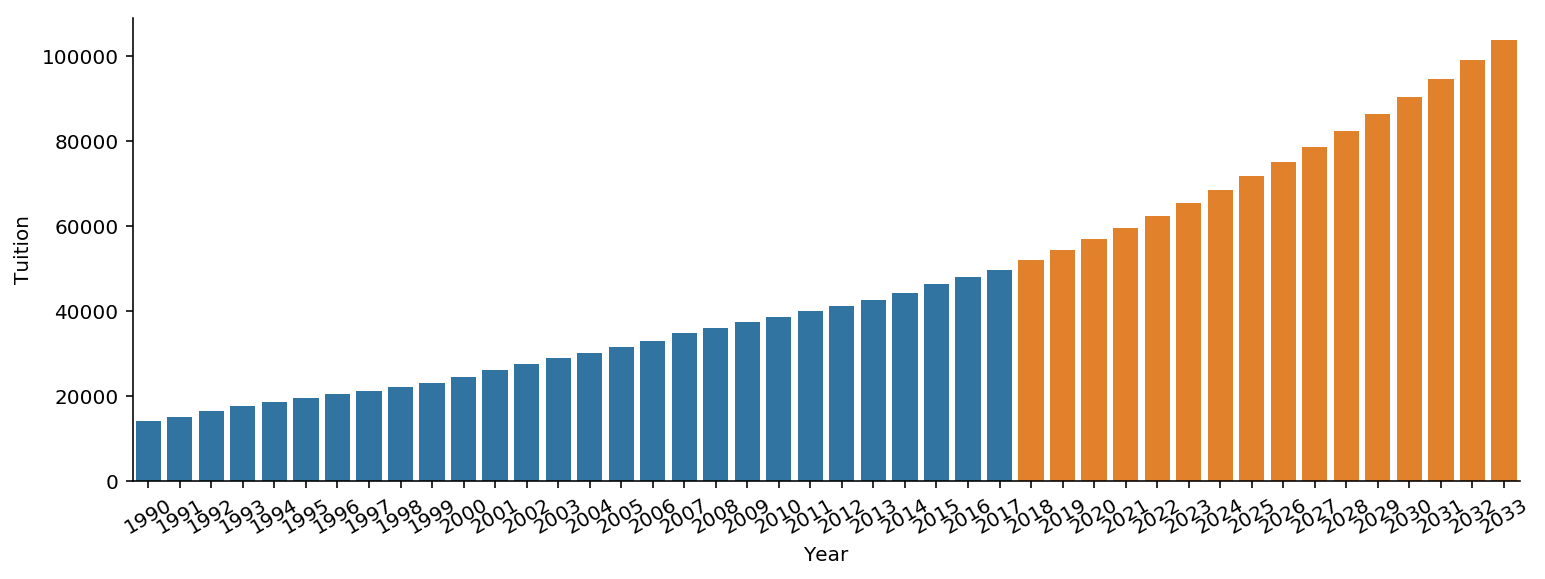

In [12]:
def predict(model, start=None, end=None, years=0):
    """Returns a dataframe containing predictions for the given date range
    
    This function really only exists to turn the array of predicted values 
    into a time series, i.e., a dataframe with a pandas DatetimeIndex. 
    
    Arguments:
    model -- the model being used to make predictions
    start -- the year of the start of the date range
    end -- the year of the end of the date range (inclusive)  
    years -- the number of years to predict (if end is None)
    
    """
    if start is None:
        start = pd.Timestamp.now().year
    if end is None:
        end = start + years
        
    dates = pd.date_range(str(start), str(end), freq='YS')
    df = pd.DataFrame({
        'tuition': model(dates.year).astype(int)
    }, index=dates).rename_axis('year')
    return df 


def plot_predictions(historical_data, predicted_data):
    """Plots historical and predicted amounts on a single graph
    
    Arguments:
    historical_data -- historical tuition data
    predicted_data -- predicted tuition data
    
    """
    historical_data = historical_data.copy(deep=True)
    predicted_data = predicted_data.copy(deep=True)
    historical_data['predicted'] = False
    predicted_data['predicted'] = True
    df = historical_data.append(predicted_data).drop_duplicates()
    g = sns.factorplot(data=df.reset_index(), x='year', y='tuition', 
                       kind='bar', 
                       hue='predicted',
                       dodge=False,
                       aspect=3,
                       legend=False)
    g.set_xticklabels(df.index.year.values, rotation=30) 
    g.set_xlabels('Year')
    g.set_ylabels('Tuition')


#predicted_amts = predict(cm, years=YEARS_TO_SAVE)
predicted_amts = predict(cm, historical_amts.index[-1].year + 1, YEAR_ENTERING_COLLEGE)
plot_predictions(historical_amts, predicted_amts)

Hmm, it doesn't seem completely out of the realm of possibility, but its growth does appear to accelerate a bit faster than I would've expected just by looking at the historical data. In fact, if I block out the predicted amounts and just concentrate on the historical data, it appears that the annual amounts follow a somewhat linear progression.

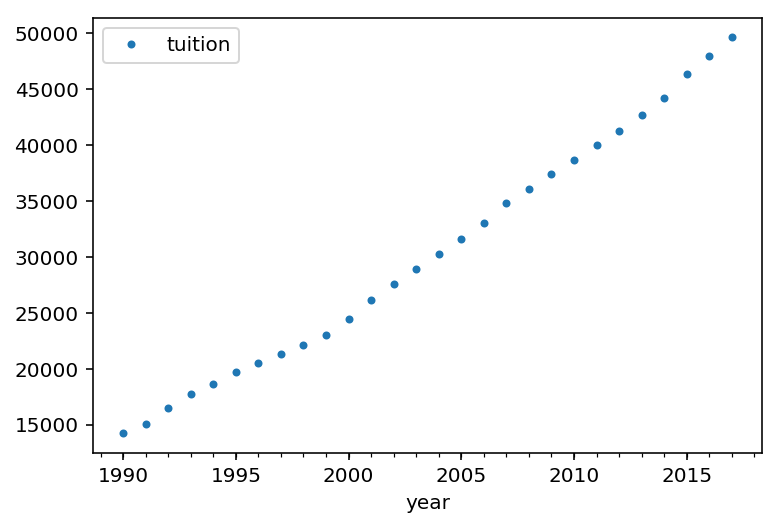

In [13]:
historical_amts.plot(style='.');

Yep, the data do look fairly linear, so maybe a simple linear regression model would be better for estimating the future cost of Ellie's college.

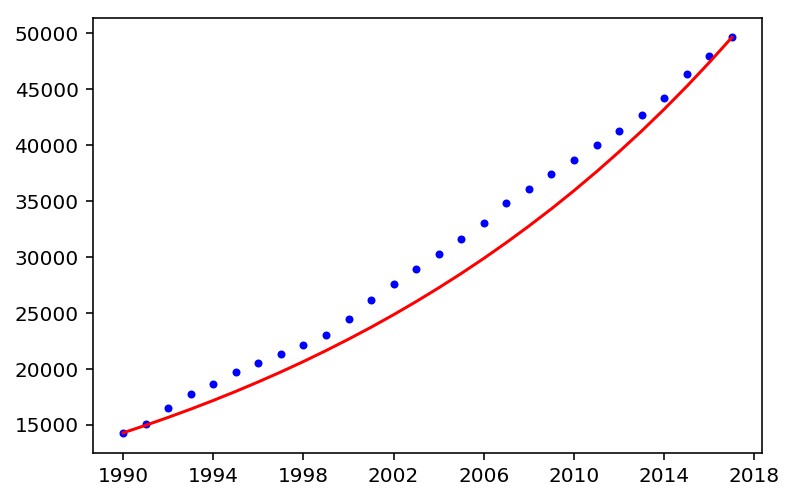

In [14]:
def plot_fit(historical_data, model):
    """Plot the model against the historical data to visualize the fit
    """
    X = historical_data.index.values
    y = historical_data.tuition.values
    y_hat = model(historical_data.index.year)
    plt.plot(X, y, 'b.', X, y_hat, 'r-');

plot_fit(historical_amts, cm)

## The CNBC Article

I finally figured out how the [CNBC team is coming up with their estimate][cnbc]. Basically, they are calculating the average tuition increase (geometric mean) over the last 18 years and using that estimate to extrapolate out the cost of attending Stanford for 4 years starting in the year 2036 (i.e., 18 years from now). The code below executes this strategy and comes up with the same amount.

[cnbc]: https://www.cnbc.com/2018/05/17/attending-harvard-will-cost-475000-in-2036-heres-how-much-other-schools-will-charge.html

In [15]:
start = str(historical_amts.index[-1].year - 18)
_cm = train_compounding_model(historical_amts[start:])
_total_cost_of_education_cm = calc_cost_of_college(_cm, 2036)
print('Total cost of education (Compounding Model): ${:,}'.format(_total_cost_of_education_cm))

Total cost of education (Compounding Model): $475,570


Using this approach, I can use the same compounding model, but with a 15 year window, instead of 18. Doing so, I get the following total cost and bi-weekly payment amounts.

In [16]:
start = str(historical_amts.index[-1].year - 15)
_cm = train_compounding_model(historical_amts[start:])
_total_cost_of_education_cm = calc_cost_of_college(_cm, YEAR_ENTERING_COLLEGE)
print('Total cost of education (Compounding Model): ${:,}'.format(_total_cost_of_education_cm))
deposit_amt = calc_deposit_amount(_total_cost_of_education_cm, 
                                  YEARS_TO_SAVE, 
                                  NUM_PAY_PERIODS_PER_YEAR, 
                                  EXPECTED_ROI,
                                  8000)
print('Bi-weekly deposit amount: ${:,}'.format(deposit_amt))

Total cost of education (Compounding Model): $394,657
Bi-weekly deposit amount: $538


## Linear Model

In [17]:
def train_linear_model(train):
    """Trains a linear regression model with the training data
    """
    lm = np.poly1d(np.polyfit(train.index.year, 
                              train['tuition'], 1))
    return lm

lm = train_linear_model(historical_amts)

Let's take a look at the model and see how well, it fits the data.

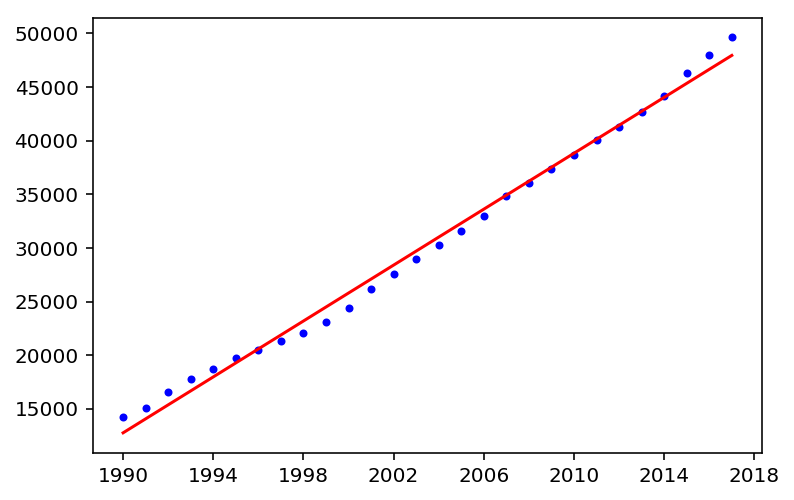

In [18]:
plot_fit(historical_amts, lm)

Not too bad. Overall, the model has a pretty tight fit on the data, so it should do a decent job with its predictions. Let's see what it looks like and what it predicts for cost of tuition when Ellie starts college.

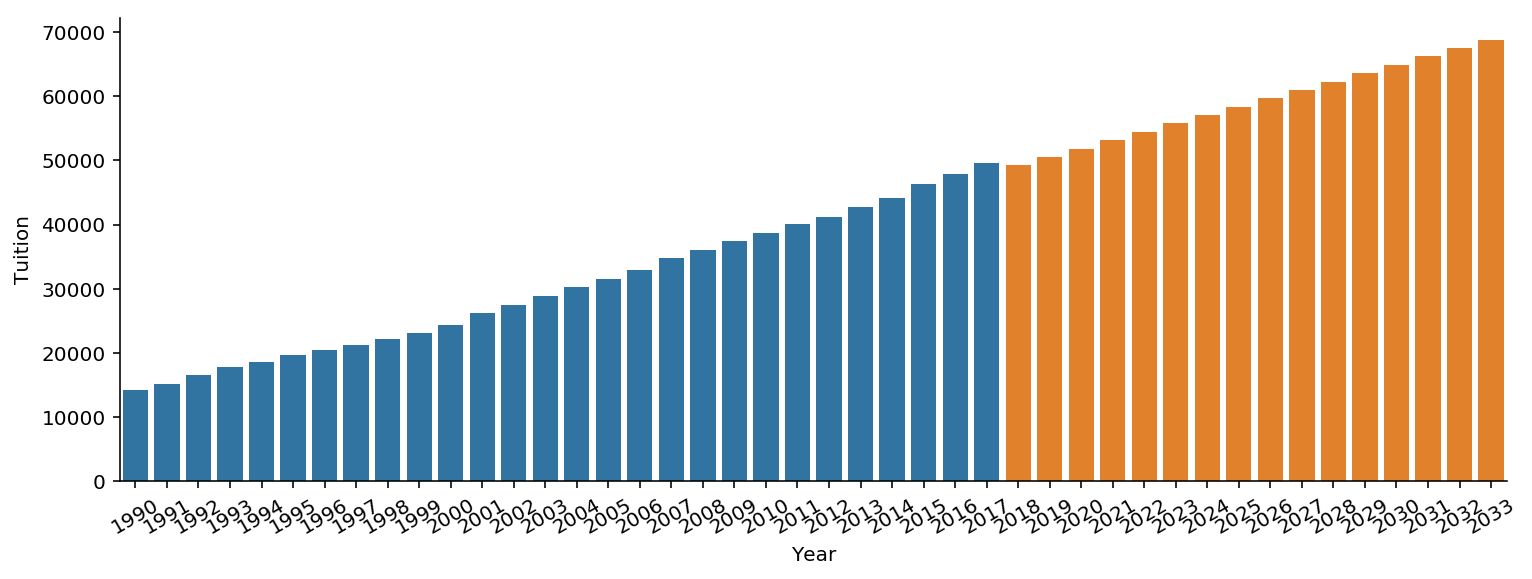

In [19]:
#predicted_amts = predict(lm, years=YEARS_TO_SAVE)
predicted_amts = predict(lm, historical_amts.index[-1].year + 1, YEAR_ENTERING_COLLEGE)
plot_predictions(historical_amts, predicted_amts)

That's not bad, the progression looks more like I would expect based on the historical data, but there's a slight stagnation between the historical and predicted amounts, which I'm pretty sure is going to prove innacurate, so this model may be a little off as well. 

In the next section, I'll look into fitting higher degree polynomial curves against the data to see if we can do even better, but let's first see what the linear model predicts for the cost of tuition for Ellie over the four years that she's at Stanford. Then, we can try a hybrid estimate by averaging the two: geometric and linear.

In [20]:
predicted_amt = int(lm(YEAR_ENTERING_COLLEGE))
print('First year cost: ${:,}'.format(predicted_amt))
total_cost_of_education_lm = calc_cost_of_college(lm, YEAR_ENTERING_COLLEGE)
print('Total cost of education: ${:,}'.format(total_cost_of_education_lm))

First year cost: $68,797
Total cost of education: $283,008


That's a much more manageable amount in total, but let's see what difference it makes for our biweekly deposit amount.

In [21]:
deposit_amt = calc_deposit_amount(total_cost_of_education_lm, 
                                  YEARS_TO_SAVE, 
                                  NUM_PAY_PERIODS_PER_YEAR, 
                                  EXPECTED_ROI,
                                  8000)
print('Bi-weekly deposit amount: ${:,}'.format(deposit_amt))

Bi-weekly deposit amount: $377


## Polynomial Model

In [22]:
def rmse(predictions, targets):
    """Calculates the Root Mean Squared Error
    """
    return np.sqrt(((predictions - targets)**2).mean())


def train_polynomial_model(data, folds=500):
    """Returns a best fit polynomial model
    
    Performs cross validation to determine the best fit polynomial 
    regression model.
    
    Arguments:
    data -- the training data
    
    Keyword Arguments:
    folds -- the number of folds (i.e., iterations) in the cross validation
    
    """
    # We don't want to overfit the data, so let's keep our polynomial 
    # relativley simple by limiting the degree to no more than half
    # the number of observations in our dataset.
    degrees = len(data)//2
    rmses = [0] * degrees
    for i in range(folds):
        train = data.sample(frac=0.5)
        test = data.drop(train.index)
        for deg in range(1, degrees + 1):
            model = np.poly1d(np.polyfit(train.index.year, train['tuition'], deg))
            predictions = model(test.index.year)
            score = rmse(predictions, test['tuition'])        
            # Calculate the running average of each "fold"
            rmses[deg-1] = (rmses[deg-1] * i + score)/(i + 1)

    # Get the degree for the best (i.e., lowest avg. RMSE) polynomial model
    best_deg_poly = rmses.index(min(rmses)) + 1    
    pm = np.poly1d(np.polyfit(data.index.year, 
                              data['tuition'], 
                              best_deg_poly))

    return pm

pm = train_polynomial_model(historical_amts)

print('Top performing n-degree polynomial: {}'.format(pm.order))

Top performing n-degree polynomial: 2


It appers that a 2nd degree polynomial is the highest performing model in our tests. So, let's create a model based on a quadratic curve fit to our data and see how its predictions look.

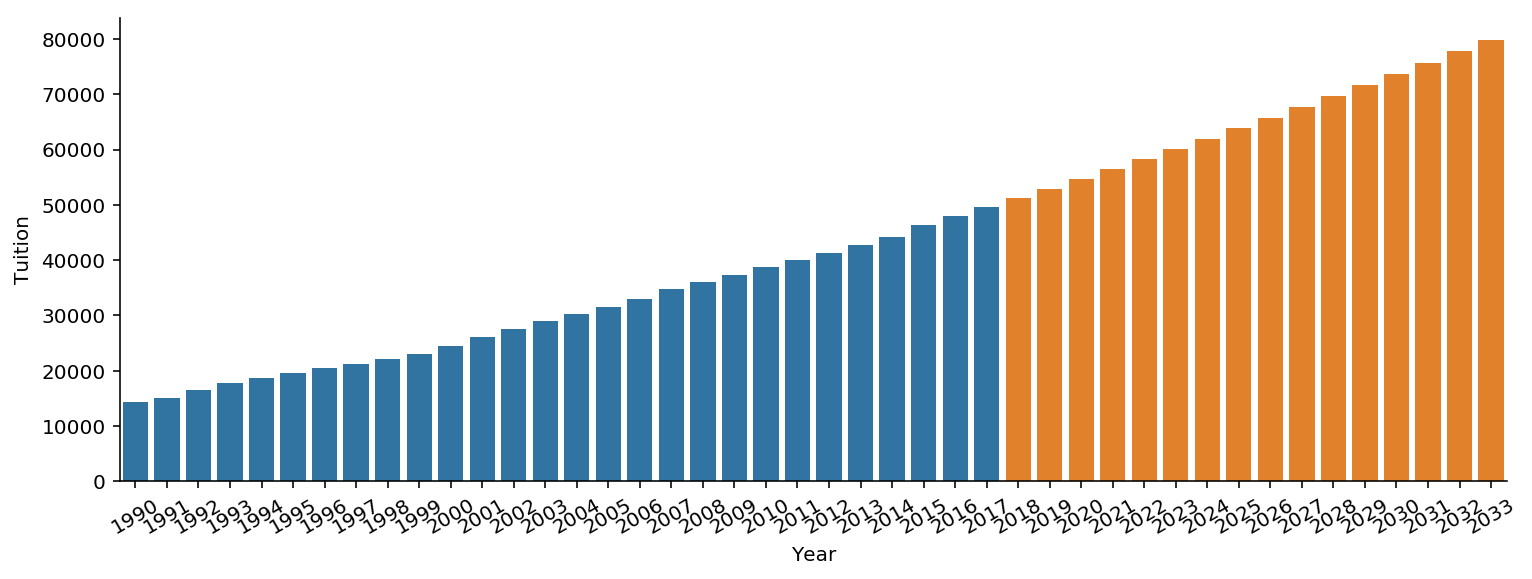

In [23]:
#predicted_amts = predict(pm, years=YEARS_TO_SAVE)
predicted_amts = predict(pm, historical_amts.index[-1].year + 1, YEAR_ENTERING_COLLEGE)
plot_predictions(historical_amts, predicted_amts)

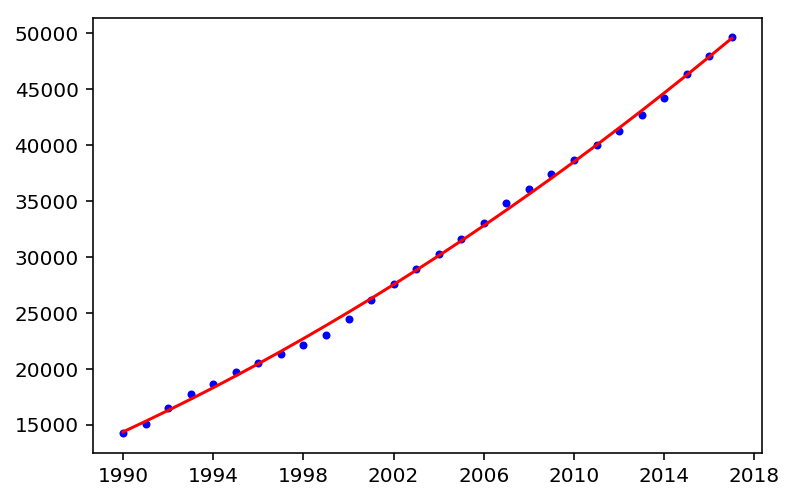

In [24]:
plot_fit(historical_amts, pm)

That's not a gigantic difference compared to the linear model, but it does smooth out that tiny little dip in tuition costs between the historical data and the predicted data, which gives me much more confidence in this model's predictive capabilities. On the whole, this model looks really good, but let's see how they all look together.

In [25]:
total_cost_of_education_pm = int(calc_cost_of_college(pm, YEAR_ENTERING_COLLEGE))
print('Total cost of education: ${:,}'.format(total_cost_of_education_pm))
deposit_amt = calc_deposit_amount(total_cost_of_education_pm, 
                                  YEARS_TO_SAVE, 
                                  NUM_PAY_PERIODS_PER_YEAR, 
                                  EXPECTED_ROI,
                                  8000)
print('Bi-weekly deposit amount: ${:,}'.format(deposit_amt))

Total cost of education: $332,256
Bi-weekly deposit amount: $448


Total cost of education (Compounding Model): $445,505
Total cost of education (Linear Model)     : $283,008
Total cost of education (Polynomial Model) : $332,256


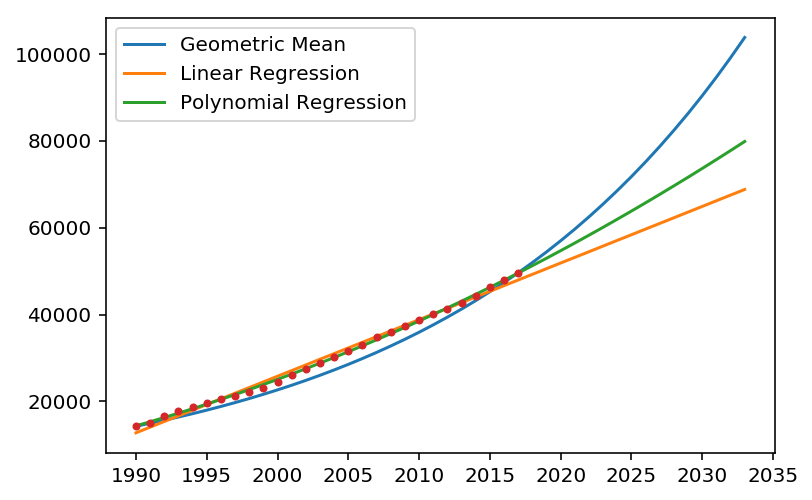

In [26]:
X = pd.date_range(str(historical_amts.index[0].year), 
                  str(YEAR_ENTERING_COLLEGE), freq='YS')
y1 = [int(cm(y)) for y in X.year]
y2 = lm(X.year)
y3 = pm(X.year)
plt.plot(X, y1, label='Geometric Mean')
plt.plot(X, y2, label='Linear Regression')  
plt.plot(X, y3, label='Polynomial Regression')
plt.plot(historical_amts.index.values, historical_amts.tuition.values, '.')
plt.legend()

print('Total cost of education (Compounding Model): ${:,}'.format(total_cost_of_education_cm))
print('Total cost of education (Linear Model)     : ${:,}'.format(total_cost_of_education_lm))
print('Total cost of education (Polynomial Model) : ${:,}'.format(total_cost_of_education_pm))

Yep, that's what I thought, when compared to the two polynomical regressions, the geometric mean model looks too extreme to be accurate---not to mention its curve doesn't fit the known data as well either. I feel confident throwing that model out and instead going with the results from the quadratic curve we fit in the previous cells.

So, with our model now chosen, let's see what the total bill is going to look like.

## Conclusion

In short, looking at the predictions made using the geometric mean to find the average rate of increase (the most aggressive estimate), we will need to have saved up approximately **\$445k** by saving around **\$600 per paycheck**. The more conservative estimate has us saving up right around **\$283k** in total by saving roughly **\$380 per paycheck**. And, finally, the middle of the road quadratic model would have us save **\$332k** in total by stashing away **\$450 per paycheck**.

# Bias-Variance Tradeoff

After playing around with the models and the data a bit, I've noticed that the polynomial regression model, which at one point was my favorite, seems to have significant issues when the training data is changed. Specifically, I am seeing a huge difference in the models generated when the training data is changed, which seems to suggest that the model is overfitting the training data. 

To illustrate this problem, the code below slides a 10-year window across the historical data and uses that slice as the training data for each of the 3 model types. I then plot the total costs that each model calculates based on the given training data.

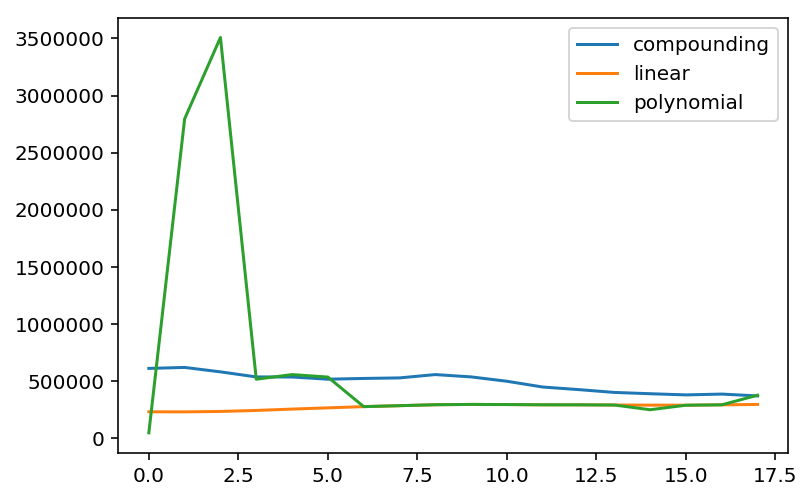

In [27]:
costs = {
    'compounding': [],
    'linear': [],
    'polynomial': []
}

# The slice is inclusive and we only want 10 years at a time, so 
# I'm adding 9 years to the start of the window instead of 10.
window_offset = 9
start = historical_amts.index[0].year
end = historical_amts.index[-1].year - window_offset
for i in range(start, end):
    window = historical_amts[str(i):str(i + window_offset)]
    _cm = train_compounding_model(window)
    _lm = train_linear_model(window)
    _pm = train_polynomial_model(window, folds=250)
    costs['compounding'].append(calc_cost_of_college(_cm, YEAR_ENTERING_COLLEGE))
    costs['linear'].append(calc_cost_of_college(_lm, YEAR_ENTERING_COLLEGE))
    costs['polynomial'].append(calc_cost_of_college(_pm, YEAR_ENTERING_COLLEGE))    

costs = pd.DataFrame(costs)
costs.plot();

As you can easily see from the plot above, the training data used has an extreme effect on the output of the polynomial model. Depending on what slice of the data is used for training, the polynomial model predicts anywhere from \$50k to \$3.5M for the total cost of attending Stanford. This is a classic example of overfitting as our model has reduced its bias at the cost of greatly increasing its variance. The model could still be useful, but we'll need to find a way to make it reduce its variance a tad. So, my next step will be to try to dampen the effect of each coefficient on the overall model through L1 or L2 normalization. 

| Coefficient | Value                                      |
|-------------|--------------------------------------------|
| $\beta_0$   | {{ print('{:,.2f}'.format(pm.c[2])) }}     |
| $\beta_1$   | {{ print('{:,.2f}'.format(pm.c[1])) }}     |
| $\beta_2$   | {{ print('{:,.2f}'.format(pm.c[0])) }}     |

## Cross-validation and Regularization: Polynomial Part II

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score

In [29]:
lreg = LinearRegression()

In [384]:
X = historical_amts.index.year.values.reshape(-1, 1)
y = historical_amts.tuition.values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [31]:
lreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

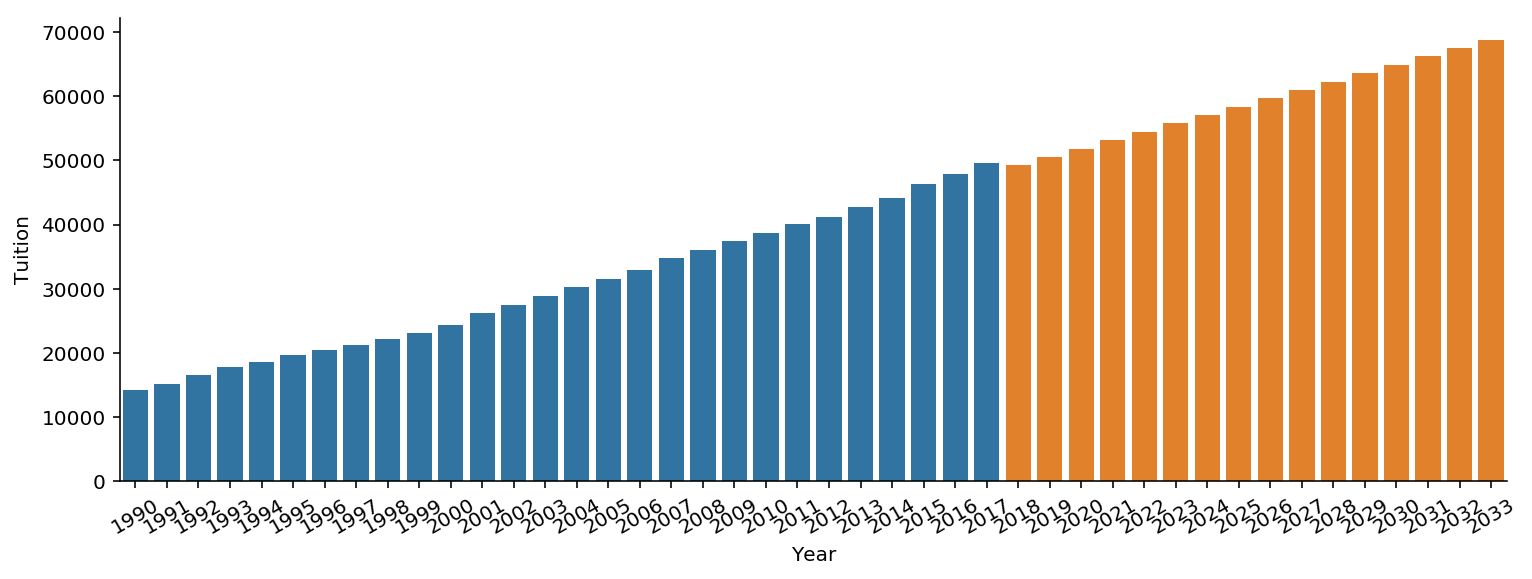

In [32]:
def model(years):
    years = years.values.reshape(-1, 1)
    predictions = lreg.predict(years).reshape(1, -1)[0]
    return predictions

predicted_amts = predict(model, 
                         historical_amts.index[-1].year + 1, 
                         YEAR_ENTERING_COLLEGE)
plot_predictions(historical_amts, predicted_amts)

## Polynomial Regression and Regularization 

In [380]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [381]:
alphas = [0.5, 1, 10, 100, 1000, 2000, 3000, 4000, 5000, 6000, 10000]
pmr = make_pipeline(PolynomialFeatures(3), RidgeCV(alphas))

In [389]:
X = historical_amts.index.year.values.reshape(-1, 1)
y = historical_amts.tuition.values.reshape(-1, 1)
pmr.fit(X, y)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridgecv', RidgeCV(alphas=[0.5, 1, 10, 100, 1000, 2000, 3000, 4000, 5000, 6000, 10000],
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False))])

In [386]:
pmr.predict(2033)

array([[79380.32099875]])

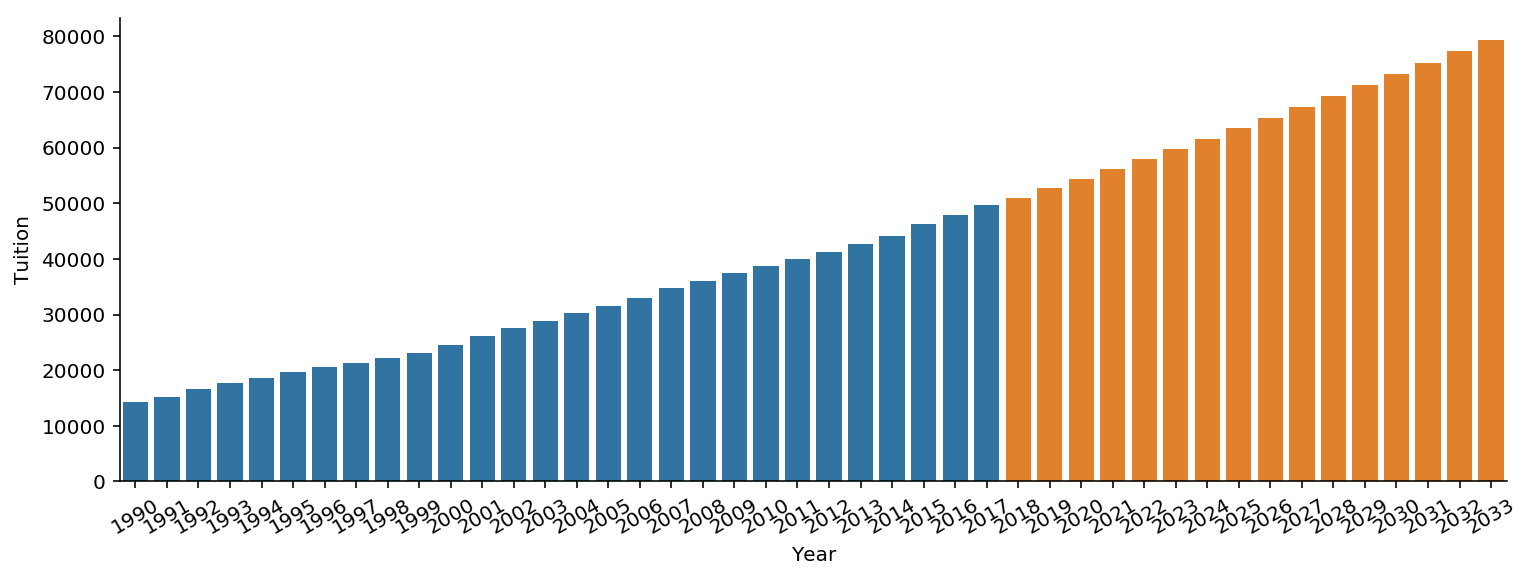

In [387]:
def model(years):
    years = years.values.reshape(-1, 1)
    predictions = pmr.predict(years).reshape(1, -1)[0]
    return predictions

predicted_amts = predict(model, 
                         historical_amts.index[-1].year + 1, 
                         YEAR_ENTERING_COLLEGE)
plot_predictions(historical_amts, predicted_amts)

In [388]:
predicted_amt = int(pmr.predict(YEAR_ENTERING_COLLEGE))
print('First year cost: ${:,}'.format(predicted_amt))
total_cost_of_education_pmr = calc_cost_of_college(lambda y: pmr.predict(y), YEAR_ENTERING_COLLEGE)
print('Total cost of education: ${:,}'.format(total_cost_of_education_pmr))

First year cost: $79,380
Total cost of education: $330,318


Total cost of education (Compounding Model): $445,505
Total cost of education (Linear Model)     : $283,008
Total cost of education (Polynomial Model) : $332,256
Total cost of education (Ridge Model)      : $330,318


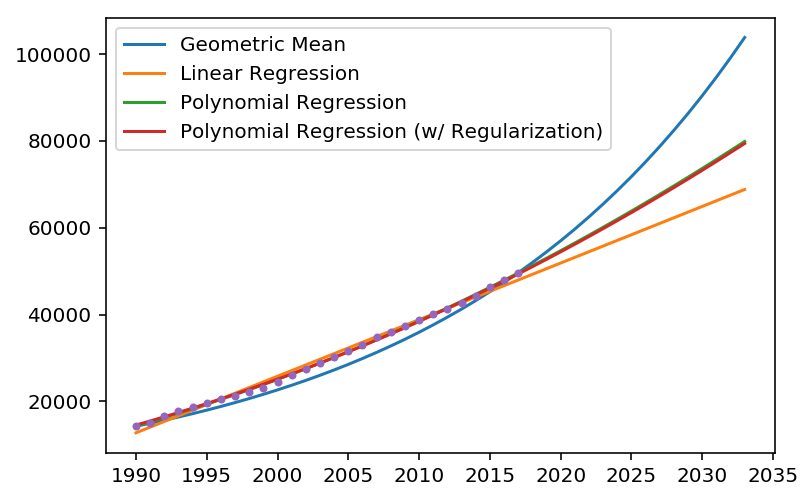

In [253]:
X_ = pd.date_range(str(historical_amts.index[0].year), 
                  str(YEAR_ENTERING_COLLEGE), freq='YS')
y1 = [int(cm(y)) for y in X_.year]
y2 = lm(X_.year)
y3 = pm(X_.year)
y4 = pmr.predict(X_.year.values.reshape(-1, 1))
plt.plot(X_, y1, label='Geometric Mean')
plt.plot(X_, y2, label='Linear Regression')  
plt.plot(X_, y3, label='Polynomial Regression')
plt.plot(X_, y4, label='Polynomial Regression (w/ Regularization)')
plt.plot(historical_amts.index.values, historical_amts.tuition.values, '.')
plt.legend()

print('Total cost of education (Compounding Model): ${:,}'.format(total_cost_of_education_cm))
print('Total cost of education (Linear Model)     : ${:,}'.format(total_cost_of_education_lm))
print('Total cost of education (Polynomial Model) : ${:,}'.format(total_cost_of_education_pm))
print('Total cost of education (Ridge Model)      : ${:,}'.format(total_cost_of_education_pmr))

## Inflation

In [308]:
inflation = pd.read_csv('inflation.csv', index_col='year', parse_dates=['year'])
tuition = pd.read_csv('stanford.csv', index_col='year', parse_dates=['year'])

In [309]:
tuition = pd.DataFrame(tuition.tuition.pct_change() * 100)

When we pull out the inflation rate increase, we notice a distinct downward trend in the increase in tuition. So, it looks like Stanford is keeping up with inflation and then adding an increase on top of that, but one that is shrinking over time. So, a good way to model this (that's obviously vastly more complex) is to try to predict both the inflation rate into the future and the trend in this "premium" over that rate and then combine them into a final prediction. The latter can be modeled via regression analysis as we've been doing, but the for the former, we may be able to use [information on government bond yields to predict inflation rates][predicting_inflation].

https://www.investopedia.com/articles/economics/08/yield-curve.asp

[predicting_inflation]: https://blog.wealthfront.com/forecast-inflation/

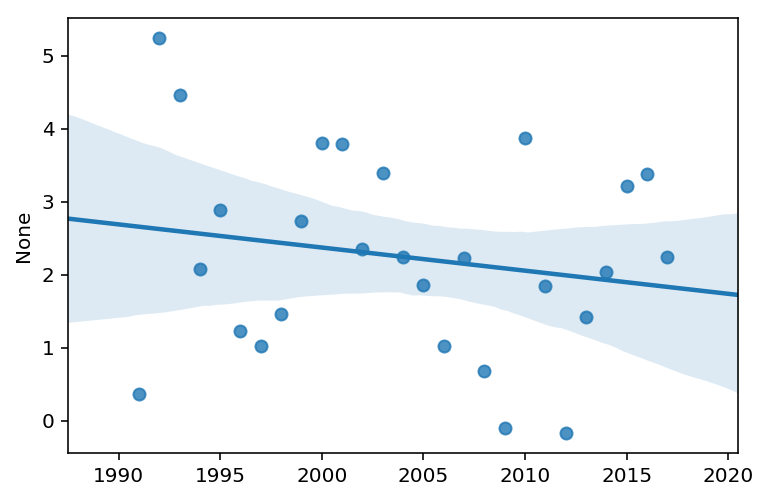

In [315]:
X = tuition.index.year.values
# I am shifting the inflation rates forward by 1 year, 
# so I can subtract the previous year's inflation rate 
# from the current year's tuition increase. In other words,
# I'm assuming that Stanford's tuition reacts to the prior
# year's increase. That said, regardless of whether I shift
# the rates or not, the trend is still the same.
y = tuition['tuition'] - inflation['inflation'].shift()
sns.regplot(X, y);

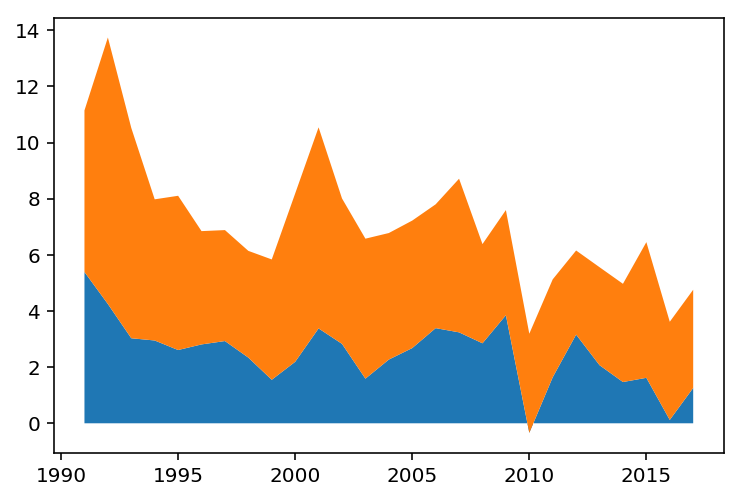

In [366]:
y1 = inflation['inflation']
y2 = tuition['tuition']
plt.stackplot(X, y1.shift(), y2);

Looking at the stacked plot above, it appears that Stanfor's tuition always lags the inflation rate by about a year. This is to be expected, since it's likely that the tuition increases are always reacting to changes in the economy rather than predicting it and making changes as the economy changes.

In [33]:
from sklearn.model_selection import TimeSeriesSplit

In [34]:
TimeSeriesSplit?

0.9212458704285746
0.22949883569039856
0.293597277916933
0.3701538646922201


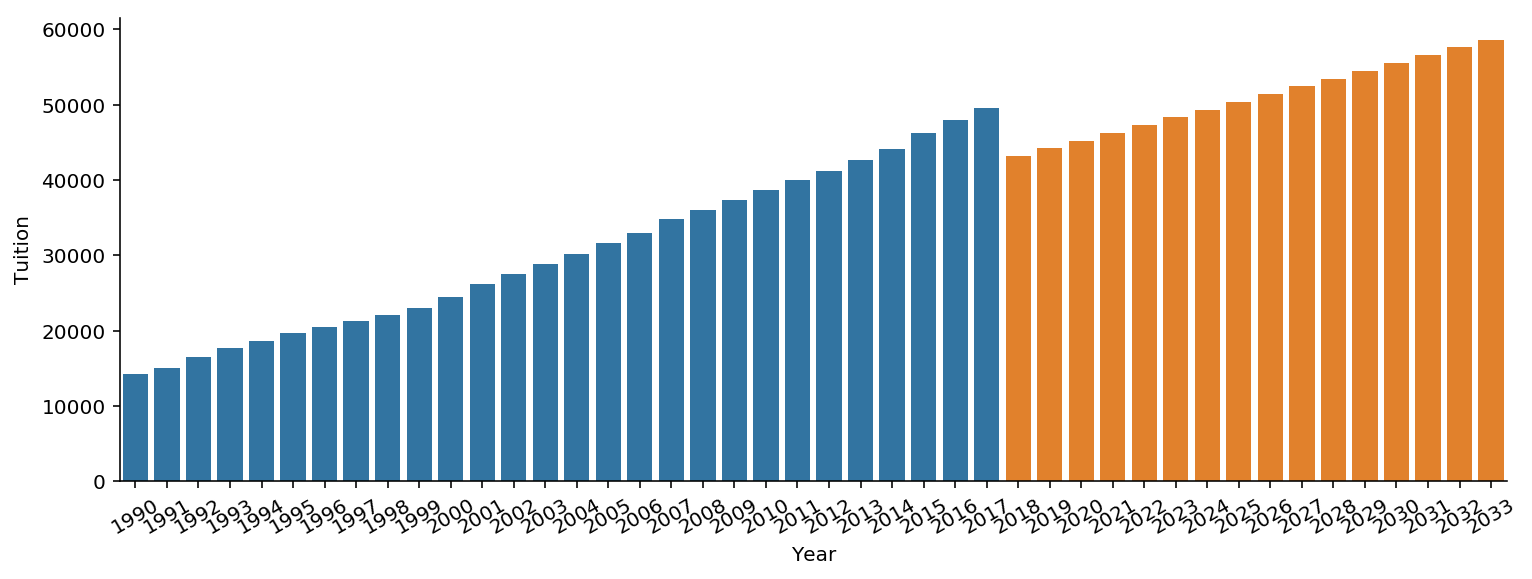

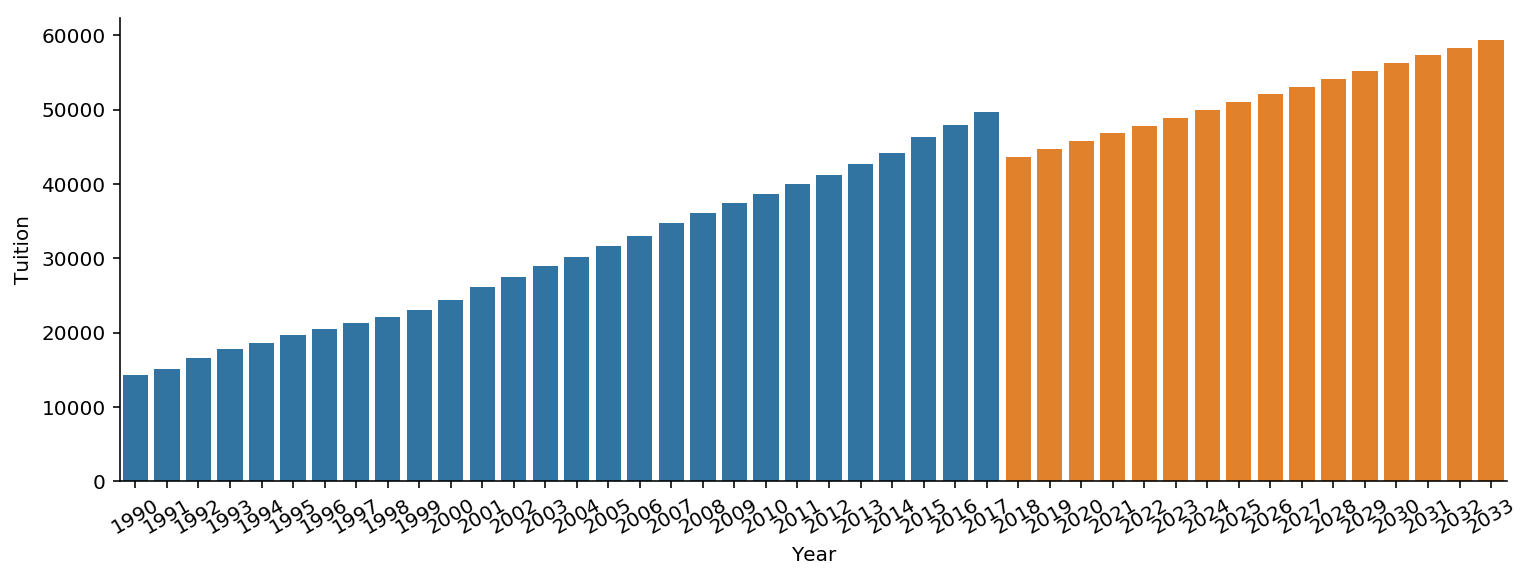

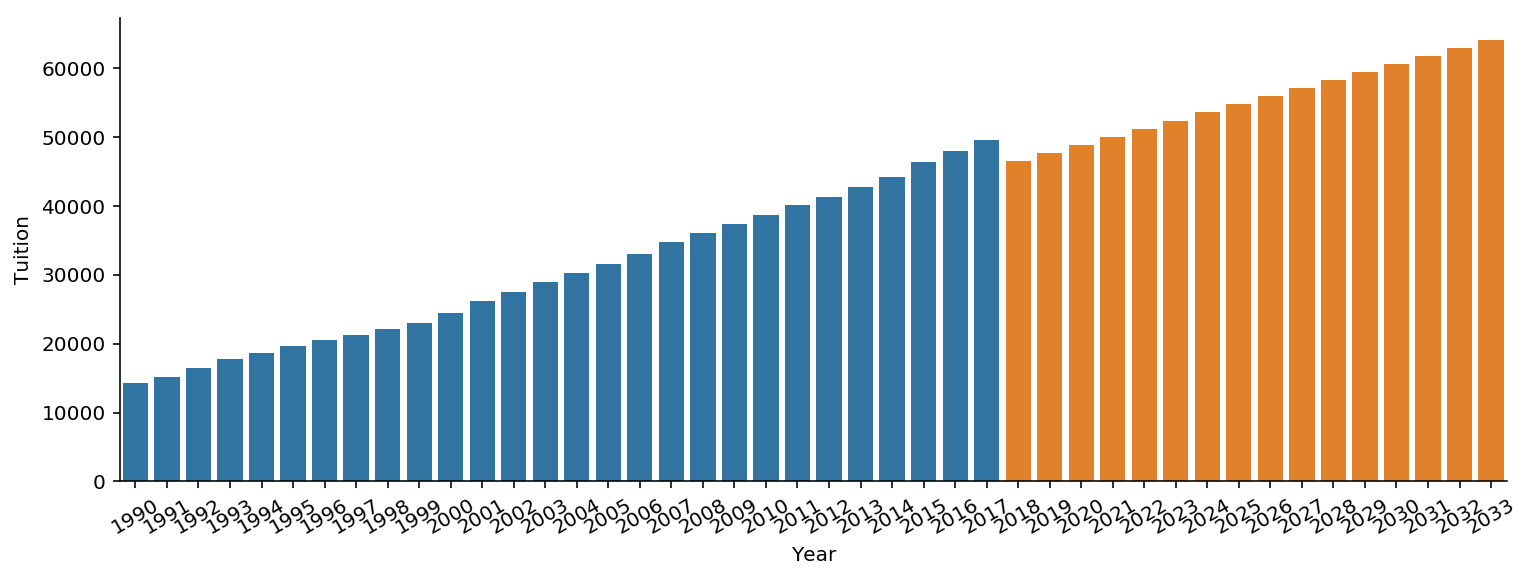

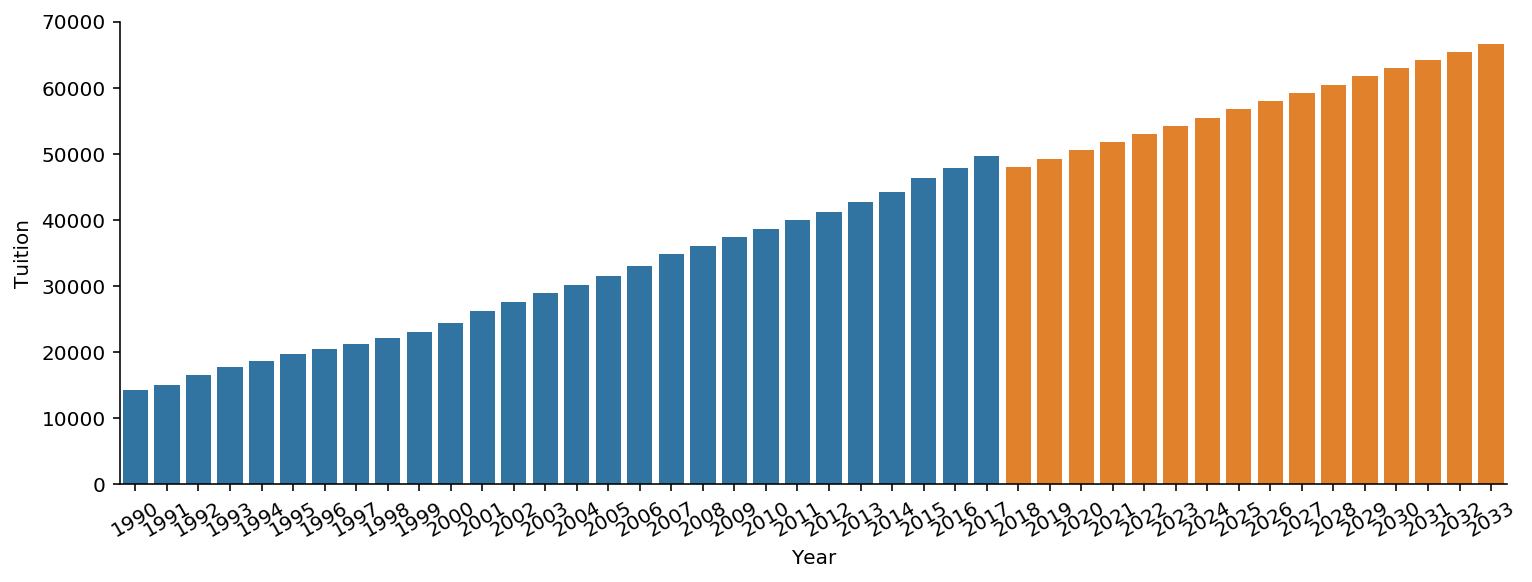

In [35]:
splits = TimeSeriesSplit(n_splits=4)

index = 1
# plt.figure(1)
for train_index, test_index in splits.split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    lreg = LinearRegression()
    lreg.fit(X_train, y_train)
    print(lreg.score(X_test, y_test))
    #plt.subplot(310 + index)

    def model(years):
        years = years.values.reshape(-1, 1)
        predictions = lreg.predict(years).reshape(1, -1)[0]
        return predictions

    predicted_amts = predict(model, 
                             historical_amts.index[-1].year + 1, 
                             YEAR_ENTERING_COLLEGE)
    plot_predictions(historical_amts, predicted_amts)    
    
    index += 1
    